Formato de hora no reconocido: 07000900
Formato de hora no reconocido: 07000900
Formato de hora no reconocido: 07000900
Formato de hora no reconocido: 07000900
Formato de hora no reconocido: 07000900
Formato de hora no reconocido: 07000900
Formato de hora no reconocido: 07000900
Formato de hora no reconocido: 07000900
Formato de hora no reconocido: 07000900
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


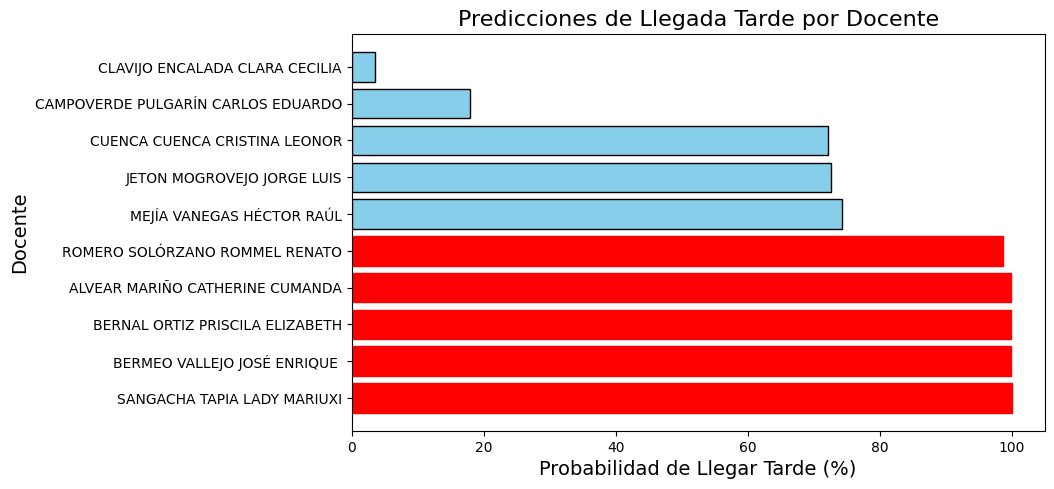

In [1]:
import tkinter as tk
from tkinter import ttk, messagebox
import mysql.connector
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import re
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

MODEL_PATH = 'modelo_prediccion.h5'

def setup_mysql_connection():
    try:
        conn = mysql.connector.connect(
            host="localhost",
            user="root",
            password="",
            database="pf_v4"
        )
        return conn
    except mysql.connector.Error as err:
        print(f"Error: {err}")
        return None

def cargar_datos():
    conn = setup_mysql_connection()
    if conn is None:
        messagebox.showerror("Error", "No se pudo conectar a la base de datos.")
        return
    
    cursor = conn.cursor()
    query = '''
        SELECT DISTINCT
            d.nombre_docente,
            h.hora_ingreso,
            dt.fecha_hora AS hora_detectada,
            v.placa AS placa_detectada
        FROM 
            deteccion dt
        JOIN 
            vehiculo v ON dt.id_vehiculo = v.id_vehiculo
        JOIN 
            docente d ON v.id_docente = d.id_docente
        JOIN 
            horarios h ON d.id_docente = h.id_docente
        WHERE 
            dt.id_placa_detectada IS NOT NULL
            AND dt.fecha_hora BETWEEN '2025-01-13' AND '2025-01-22'
        ORDER BY 
            dt.fecha_hora;
    '''
    try:
        cursor.execute(query)
        rows = cursor.fetchall()
        for item in tree.get_children():
            tree.delete(item)
        for row in rows:
            tree.insert("", "end", values=row)
    except Exception as e:
        print(f"Error al ejecutar la consulta: {e}")
    finally:
        cursor.close()
        conn.close()

def convertir_hora_a_numero(hora):
    if isinstance(hora, str):
        hora = re.sub(r'[^0-9]', '', hora).strip()
        if len(hora) == 4:
            hora = f"{hora[:2]}:{hora[2:]}"
        elif len(hora) == 6:
            hora = f"{hora[:2]}:{hora[2:4]}:{hora[4:]}"
        
        try:
            hora = datetime.strptime(hora, "%H:%M").time()
        except ValueError:
            try:
                hora = datetime.strptime(hora, "%H:%M:%S").time()
            except ValueError:
                print(f"Formato de hora no reconocido: {hora}")
                return 0  # Devolver 0 en caso de error
    return hora.hour + hora.minute / 60.0

def entrenar_o_cargar_modelo(X_scaled, y):
    if os.path.exists(MODEL_PATH):
        model = load_model(MODEL_PATH)
    else:
        model = Sequential([
            Dense(64, activation='relu', input_shape=(X_scaled.shape[1],)),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])
        
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_scaled, y, epochs=200, batch_size=32, verbose=0)
        model.save(MODEL_PATH)

    return model

def realizar_prediccion():
    messagebox.showinfo("Cargando", "Entrenando modelo, por favor espere...")

    conn = setup_mysql_connection()
    if conn is None:
        messagebox.showerror("Error", "No se pudo conectar a la base de datos.")
        return
    
    cursor = conn.cursor()
    query = '''
        SELECT DISTINCT
            d.nombre_docente,
            h.hora_ingreso,
            dt.fecha_hora AS hora_detectada
        FROM 
            horarios h
        JOIN 
            docente d ON h.id_docente = d.id_docente
        JOIN 
            vehiculo v ON d.id_docente = v.id_docente
        JOIN 
            deteccion dt ON v.id_vehiculo = dt.id_vehiculo
        WHERE 
            dt.id_placa_detectada IS NOT NULL
            AND dt.fecha_hora BETWEEN '2025-01-13' AND '2025-01-22';
    '''
    try:
        cursor.execute(query)
        data = cursor.fetchall()
        if not data:
            messagebox.showinfo("Información", "No hay datos para realizar la predicción.")
            return

        nombres = []
        horas_ingreso = []
        horas_detectada = []
        llego_tarde = []

        docentes_unicos = {}

        for row in data:
            docente = row[0]
            hora_ingreso = convertir_hora_a_numero(row[1])
            hora_detectada = convertir_hora_a_numero(row[2])
            retraso = hora_detectada - hora_ingreso

            if docente not in docentes_unicos or retraso > docentes_unicos[docente]:
                docentes_unicos[docente] = retraso

        for docente, retraso in docentes_unicos.items():
            nombres.append(docente)
            horas_ingreso.append(7.5)  # Hora de ingreso estándar
            horas_detectada.append(horas_ingreso[-1] + retraso)
            llego_tarde.append(1 if retraso > 0 else 0)

        X = np.column_stack((horas_ingreso, horas_detectada))
        y = np.array(llego_tarde)

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        model = entrenar_o_cargar_modelo(X_scaled, y)

        predictions = model.predict(X_scaled)
        pred_result = (predictions > 0.5).astype(int)

        docentes_info = []
        for i, pred in enumerate(pred_result):
            probabilidad = predictions[i][0] * 100
            docentes_info.append((nombres[i], probabilidad, 'Tarde' if pred[0] == 1 else 'A tiempo'))

        docentes_info.sort(key=lambda x: x[1], reverse=True)

        resultado = "Los 5 docentes con mayor probabilidad de llegar tarde:\n"
        for docente, probabilidad, pred in docentes_info[:5]:
            resultado += f"{docente}: {probabilidad:.2f}% - {pred}\n"

        resultado += "\nLos 5 docentes con menor probabilidad de llegar tarde:\n"
        for docente, probabilidad, pred in docentes_info[-5:]:
            resultado += f"{docente}: {probabilidad:.2f}% - {pred}\n"

        resultado += "\nTotal de docentes: " + str(len(docentes_info))

        label_resultado.config(text=resultado)

        # Filtramos solo los docentes que han sido considerados en las probabilidades
        docentes_info_filtrados = docentes_info[:5] + docentes_info[-5:]

        # Graficar las predicciones solo para los docentes filtrados
        nombres_docentes = [docente for docente, _, _ in docentes_info_filtrados]
        probabilidades = [probabilidad for _, probabilidad, _ in docentes_info_filtrados]

        fig, ax = plt.subplots(figsize=(18, 10))  # Aumentando el tamaño de la gráfica
        bars = ax.barh(nombres_docentes, probabilidades, color='skyblue', edgecolor='black', height=0.8)  # Separar las barras

        # Resaltar solo los que tienen probabilidad mayor a 80%
        for i, bar in enumerate(bars):
            if probabilidades[i] > 80:  # Solo resaltar si la probabilidad es mayor a 80%
                bar.set_color('red')

        ax.set_xlabel('Probabilidad de Llegar Tarde (%)', fontsize=14)
        ax.set_ylabel('Docente', fontsize=14)
        ax.set_title('Predicciones de Llegada Tarde por Docente', fontsize=16)

        # Mostrar la gráfica en la ventana Tkinter
        canvas = FigureCanvasTkAgg(fig, master=frame_right)
        canvas.draw()
        canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        # Reducir el tamaño del texto de las predicciones
        label_resultado.config(font=("Arial", 8))  # Reducción del tamaño de texto

    except Exception as e:
        print(f"Error en la predicción: {e}")
    finally:
        cursor.close()
        conn.close()


root = tk.Tk()
root.title("Detección de Placas - Reportes")
root.state("zoomed")  # Para pantalla completa en modo ventana

frame = tk.Frame(root)
frame.pack(fill=tk.BOTH, expand=True)

frame_left = tk.Frame(frame)
frame_left.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

frame_top_left = tk.Frame(frame_left)
frame_top_left.pack(side=tk.TOP, fill=tk.X, pady=10)

label_title = tk.Label(frame_top_left, text="Sistema de Reconocimiento de Placas Automatizado", font=("Arial", 16, "bold"))
label_title.pack(side=tk.BOTTOM, padx=20)

columns = ("Nombre Docente", "Hora Ingreso", "Hora Detectada", "Placa Detectada")
tree = ttk.Treeview(frame_left, columns=columns, show="headings")
tree.pack(fill=tk.BOTH, expand=True, padx=20)

for col in columns:
    tree.heading(col, text=col, anchor=tk.W)
    tree.column(col, anchor=tk.W, width=150)

frame_buttons_left = tk.Frame(frame_left)
frame_buttons_left.pack(side=tk.TOP, fill=tk.X, pady=10)

button_cargar = tk.Button(frame_buttons_left, text="Cargar Datos", command=cargar_datos)
button_cargar.pack(side=tk.LEFT, padx=10)

button_predict = tk.Button(frame_buttons_left, text="Predecir Llegada Tarde", command=realizar_prediccion)
button_predict.pack(side=tk.LEFT)

frame_right = tk.Frame(frame)
frame_right.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)

# Etiqueta para el texto "Filtrado de docentes" alineado a la izquierda
label_filtrado = tk.Label(frame_right, text="Filtrado de docentes", font=("Arial", 10, "bold"))
label_filtrado.pack(side=tk.TOP, anchor=tk.W, padx=10)  # Alineado a la izquierda

label_resultado = tk.Label(frame_right, text="Resultados de la predicción...", font=("Arial", 8))
label_resultado.pack(side=tk.TOP, anchor=tk.W, padx=10, pady=20)

root.mainloop()
